# Weather Analysis: Little Rock, AR vs. Wellington, NZ

## Introduction
This report compares the seasonal climates of **Little Rock, Arkansas** and **Wellington, New Zealand** over the last 5 years. 

**Note:** The request specified 'Wellington, NX'. We have assumed this refers to Wellington, NZ (New Zealand).

### Metrics Analyzed
1. **Averages** (Highs/Lows) by Season
2. **Standard Deviation & Variance** (Volatility)
3. **Covariance** (Relationship between locations and daily temperature spreads)
4. **Visualization** of High/Low trends

In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Setup Plotting Style
plt.style.use('ggplot')
%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


## 1. Data Ingestion
Fetching daily historical weather data from the **Open-Meteo API** for the last 5 years.

In [3]:
# 1. Configuration
locations = {
    "Little Rock, AR": {"lat": 34.7445, "lon": -92.2880, "hemisphere": "North"},
    "Wellington, NZ":  {"lat": -41.2865, "lon": 174.7762, "hemisphere": "South"}
}

end_date = datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=5*365)).strftime('%Y-%m-%d')

# 2. Fetch Data Function
def get_weather_data(lat, lon, city, start, end):
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start,
        "end_date": end,
        "daily": ["temperature_2m_max", "temperature_2m_min"],
        "timezone": "auto"
    }
    response = requests.get(url, params=params)
    data = response.json()
    
    df = pd.DataFrame({
        'Date': pd.to_datetime(data['daily']['time']),
        'Max_Temp': data['daily']['temperature_2m_max'],
        'Min_Temp': data['daily']['temperature_2m_min']
    })
    df['Avg_Temp'] = (df['Max_Temp'] + df['Min_Temp']) / 2
    df['City'] = city
    return df

# 3. Compile Data
data_frames = []
for city, coords in locations.items():
    print(f"Fetching data for {city}...")
    df = get_weather_data(coords['lat'], coords['lon'], city, start_date, end_date)
    df['Hemisphere'] = coords['hemisphere']
    data_frames.append(df)

weather_df = pd.concat(data_frames).reset_index(drop=True)
weather_df.head()

Fetching data for Little Rock, AR...
Fetching data for Wellington, NZ...


,Date,Max_Temp,Min_Temp,Avg_Temp,City,Hemisphere
0,2020-11-19,20.7,8.3,14.50,"Little Rock, AR",North
1,2020-11-20,21.5,11.9,16.70,"Little Rock, AR",North
2,2020-11-21,21.8,13.0,17.40,"Little Rock, AR",North
3,2020-11-22,16.9,6.1,11.50,"Little Rock, AR",North
4,2020-11-23,12.8,2.1,7.45,"Little Rock, AR",North


## 2. Seasonal Analysis
We must calculate seasons differently based on the hemisphere.
- **North:** Winter (Dec-Feb), Spring (Mar-May), Summer (Jun-Aug), Fall (Sep-Nov)
- **South:** Summer (Dec-Feb), Fall (Mar-May), Winter (Jun-Aug), Spring (Sep-Nov)

In [4]:
def get_season(row):
    month = row['Date'].month
    hemi = row['Hemisphere']
    
    if month in [12, 1, 2]:
        return 'Winter' if hemi == 'North' else 'Summer'
    elif month in [3, 4, 5]:
        return 'Spring' if hemi == 'North' else 'Fall'
    elif month in [6, 7, 8]:
        return 'Summer' if hemi == 'North' else 'Winter'
    else:
        return 'Fall' if hemi == 'North' else 'Spring'

weather_df['Season'] = weather_df.apply(get_season, axis=1)

# Calculate Aggregates: Mean, Std Dev, Variance
stats = weather_df.groupby(['City', 'Season'])['Avg_Temp'].agg(['mean', 'std', 'var'])

# Reorder for readability
season_order = ['Spring', 'Summer', 'Fall', 'Winter']
stats = stats.reindex(pd.MultiIndex.from_product([weather_df['City'].unique(), season_order], names=['City', 'Season']))

display(stats.style.format("{:.2f}").background_gradient(cmap='coolwarm'))

## 3. Covariance Analysis
1. **Location Covariance:** Comparing the Avg Temps of the two cities. (Expected: Negative, as seasons are opposite).
2. **Daily Range Covariance:** Comparing Highs vs Lows within the same city.

In [5]:
# Cross-Location Covariance
pivot = weather_df.pivot(index='Date', columns='City', values='Avg_Temp')
loc_cov = pivot.cov()

print("Covariance: Little Rock vs Wellington (Avg Temp)")
display(loc_cov)

print("\nCovariance: Daily Highs vs Lows (Within City)")
for city in locations.keys():
    subset = weather_df[weather_df['City'] == city]
    cov_val = np.cov(subset['Max_Temp'], subset['Min_Temp'])[0][1]
    print(f"{city}: {cov_val:.2f}")

Covariance: Little Rock vs Wellington (Avg Temp)


City,"Little Rock, AR","Wellington, NZ"
City,,
"Little Rock, AR",81.483648,-18.957354
"Wellington, NZ",-18.957354,9.132370



Covariance: Daily Highs vs Lows (Within City)
Little Rock, AR: 79.08
Wellington, NZ: 8.35


## 4. 5-Year High/Low Graph
Visualizing the temperature trends.

/tmp/ipykernel_11604/3417434531.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = weather_df.groupby(['City', pd.Grouper(key='Date', freq='M')]).agg({'Max_Temp':'mean', 'Min_Temp':'mean'}).reset_index()


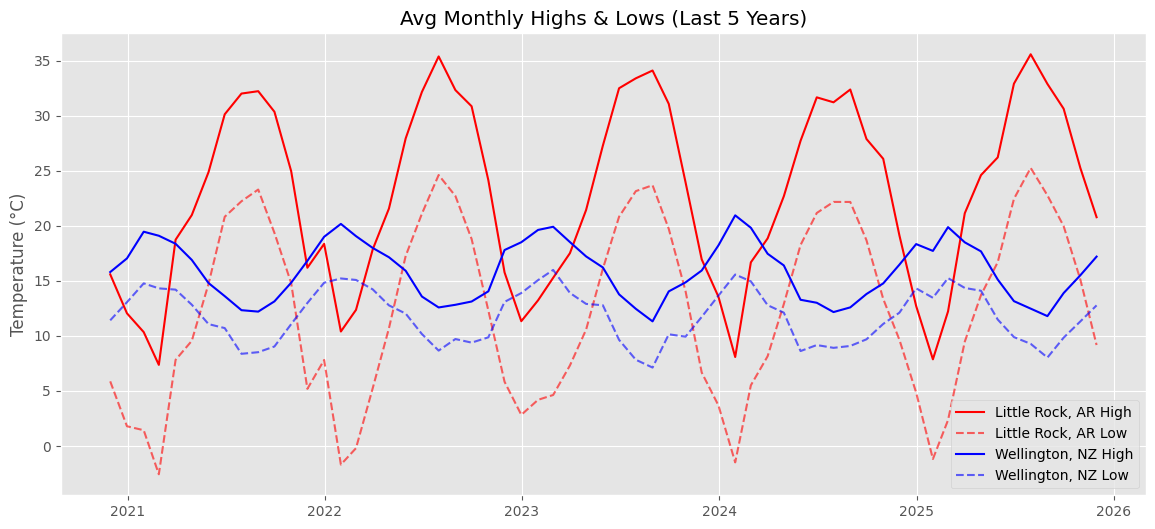

In [7]:
plt.figure(figsize=(14, 6))

# Resample to Monthly Mean for cleaner visualization
monthly = weather_df.groupby(['City', pd.Grouper(key='Date', freq='M')]).agg({'Max_Temp':'mean', 'Min_Temp':'mean'}).reset_index()

colors = {'Little Rock, AR': 'red', 'Wellington, NZ': 'blue'}

for city in locations.keys():
    subset = monthly[monthly['City'] == city]
    plt.plot(subset['Date'], subset['Max_Temp'], label=f'{city} High', color=colors[city], linestyle='-')
    plt.plot(subset['Date'], subset['Min_Temp'], label=f'{city} Low', color=colors[city], linestyle='--', alpha=0.6)

plt.title('Avg Monthly Highs & Lows (Last 5 Years)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()